In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import multiprocessing

# Basic SAW generator
Does not generate SAWs uniformly

In [3]:
DIRECTIONS = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])

In [4]:
def generate_valid_saw(L):
    while True:
        coords = [np.array([0, 0])]
        visited = set((0, 0))

        while len(coords) <= L:
            neighbours = [move + coords[-1] for move in DIRECTIONS if tuple(move + coords[-1]) not in visited]
            if len(neighbours) == 0: # no possible moves, keep still
                break
            coords.append(random.choice(neighbours))
            visited.add(tuple(coords[-1]))
        if len(coords) == L + 1:
            return np.array(coords)


Simpler generation of SAWs are required when the length of the walks get long, for example: just a straight line

In [5]:
def generate_straight_line_saw(L):
    return np.array([[i, 0] for i in range(L + 1)])

In [6]:
generate_valid_saw(10)

array([[ 0,  0],
       [ 0, -1],
       [-1, -1],
       [-1,  0],
       [ 0,  0],
       [ 0,  1],
       [ 1,  1],
       [ 1,  0],
       [ 1, -1],
       [ 1, -2],
       [ 2, -2]])

In [7]:
generate_straight_line_saw(10)

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  0],
       [ 4,  0],
       [ 5,  0],
       [ 6,  0],
       [ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [10,  0]])

# Recursive SAW formulation

Let $B(L_A, L_B)$ be the probability that when sampling SAWs of length $L_A$ and $L_B$ independently and uniformly at random, their concatenation is still a SAW.

$B(L_A, L_B) = {c_{L_A + L_B} \over c_{L_A} c_{L_B}}$

$\mu^{L_A} \approx {c_{L_A + L_B} \over c_{L_B}} = B(L_A, L_B) c_{L_A}$

We can generate samples of SAWs of length $L_A$ and $L_B$ to estimate $B(L_A, L_B)$

In [8]:
# Returns True if z_A can be concatenated with z_B
# such that the resulting SAW is valid
def can_concatenate(z_A, z_B):
    z = np.concatenate((z_A, z_B[1:]+z_A[-1])).tolist()
    return len(z) == len(set(map(tuple, z)))


def estimate_B(Z_A, Z_B):
    if len(Z_A) != len(Z_B):
        raise ValueError("Z_A and Z_B must have the same length")

    Z = zip(Z_A, Z_B)

    successes = 0
    for z_A, z_B in Z:
        if can_concatenate(z_A, z_B):
            successes += 1

    return successes / len(Z_A)


# estimates c_{L_A + L_B}
def estimate_c(Z_A, Z_B, c_L_A, c_L_B):
    return estimate_B(Z_A, Z_B) * c_L_A * c_L_B


def estimate_mu(C):
    mus = []
    for c1, c2 in zip(C[:-1], C[1:]):
        mus.append((c2[1] / c1[1]) ** (1 / c1[0]))
    return mus


# Generating SAWs with Pivot Algorithm

In [9]:
def pivot(z, pivot_generator, transform_generator):
    pivot_idx = pivot_generator(len(z)-1)
    transform = transform_generator(z)
    
    before = z[:pivot_idx + 1]
    pivot = z[pivot_idx]
    after = z[pivot_idx + 1:] - pivot
    z_new = np.vstack((before, (after @ transform.T) + pivot))

    if len(set(map(tuple, z_new))) != len(z_new):
        return z, False
    return z_new, True


def generate_saw_pivot(z, pivot_generator, transform_generator):
    successes = 0
    b = 0
    while successes < len(z):
        pivot_idx = pivot_generator(z) 
        z, success = pivot(z, lambda _: pivot_idx, transform_generator)
        if success:
            successes += 1
        b += 1
    return z


def saw_pivot_batch_generator(L, n, walk_generator, pivot_generator, transform_generator):
    z = walk_generator(L)
    Z = []
    for _ in range(10):
        z = generate_saw_pivot(z, pivot_generator, transform_generator)
    for _ in range(n):
        z = generate_saw_pivot(z, pivot_generator, transform_generator)
        Z.append(z)
    return Z

# Transformation generator

In [10]:
TRANSFORMS = [
    np.array([[1, 0], [0, 1]]), # identity
    np.array([[-1, 0], [0, 1]]), # reflect over y-axis
    np.array([[1, 0], [0, -1]]), # reflect over x-axis
    np.array([[-1, 0], [0, -1]]), # rotate 180 degrees
    np.array([[0, 1], [1, 0]]), # reflect over y=x
    np.array([[0, -1], [1, 0]]), # rotate 90 degrees counterclockwise
    np.array([[0, 1], [-1, 0]]), # rotate 90 degrees clockwise
    np.array([[0, -1], [-1, 0]]) # reflect over y=-x
]

In [11]:
# z is a param for more complex transform generators
# that take the current state of the walk into account
def naive_transform_generator(z):
    return random.choice(TRANSFORMS)


# Pivot generator

In [12]:
def uniform_pivot_generator(z):
    L = len(z)-1
    return random.randint(1, L)


def gaussian_pivot_generator(z):
    L = len(z)-1
    mean = (L + 1) / 2
    stddev = L / 4
    pivot = round(np.random.normal(mean, stddev))
    if pivot < 1:
        return 1
    elif pivot > L:
        return L
    return pivot




# Speed comparison

In [13]:
Z_1 = saw_pivot_batch_generator(10, 40_000, generate_straight_line_saw, uniform_pivot_generator, naive_transform_generator)

In [14]:
Z_2 = saw_pivot_batch_generator(10, 40_000, generate_straight_line_saw, gaussian_pivot_generator, naive_transform_generator)

# Multi-threading

In [15]:

def generator(p):
    L, no_samples = p
    return saw_pivot_batch_generator(L, no_samples, generate_straight_line_saw, uniform_pivot_generator, naive_transform_generator)

def generate_saw_pivot_multi(L, n, nbr_threads):
    
    # Calculate batch sizes
    batch_size = n // nbr_threads
    batches = [(L, batch_size)] * nbr_threads
    if n % nbr_threads != 0:
        batches[-1] = (L, batches[-1][1] + n % nbr_threads)  # Add the remainder to the last batch

    with multiprocessing.Pool(processes=nbr_threads) as pool:
        results = pool.map(generator, batches)
    
    # Combine results
    return np.vstack(results)

In [16]:
Z = generate_saw_pivot_multi(80, 10_000, 8)

# Estimation

In [17]:
C_pivot = [(10, 44100)]
n = 10_000
stopping_condition = 640 # stops when the last L is less than this value

while C_pivot[-1][0] < stopping_condition:
    L, c_L = C_pivot[-1]
    print(f'Working on L = {2*L}...')
    Z = generate_saw_pivot_multi(L, n, 8)
    C_pivot.append((L*2, estimate_c(Z[:len(Z)//2], Z[len(Z)//2:], c_L, c_L)))

Working on L = 20...
Working on L = 40...
Working on L = 80...
Working on L = 160...
Working on L = 320...
Working on L = 640...


In [18]:
C_pivot

[(10, 44100),
 (20, 954123786.0),
 (40, 3.472083287027854e+17),
 (80, 3.7540398364309074e+34),
 (160, 3.3766384964050425e+68),
 (320, 2.2096470443613934e+136),
 (640, 7.489816453044834e+271)]

In [19]:
estimate_mu(C_pivot)

[2.713417448191254,
 2.6794722928861687,
 2.6659237185511016,
 2.657203532556366,
 2.6536826782906497,
 2.6517447233739477]

In [20]:
X = np.array([L for L, _ in C_pivot])
Y1 = np.array([c_L for _, c_L in C_pivot])
Y2 = np.array([mu for mu in estimate_mu(C_pivot)])

# Visualisation

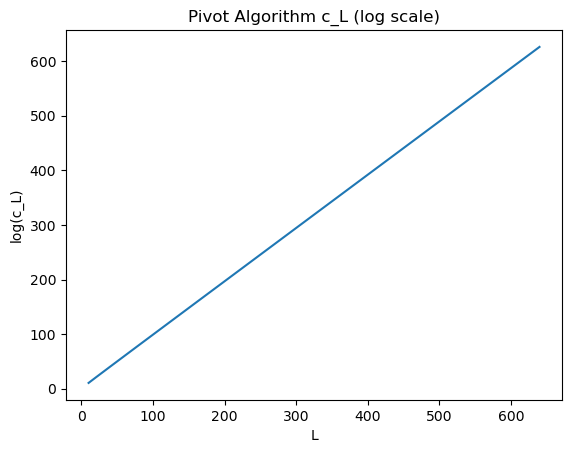

In [25]:
plt.plot(X, np.log(Y1))
plt.title("Pivot Algorithm c_L (log scale)")
plt.xlabel("L")

plt.ylabel("log(c_L)")
plt.savefig("diagrams/pivot1.png")

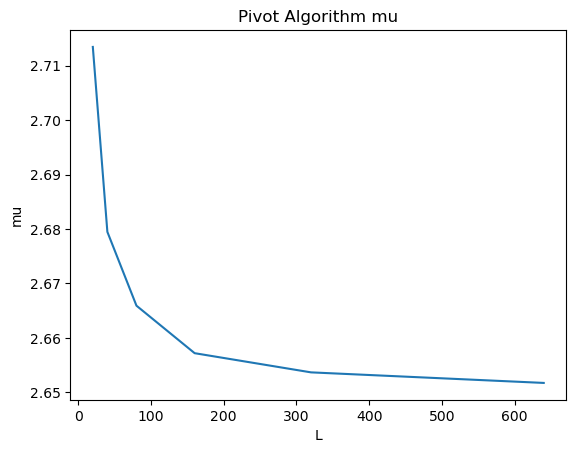

In [26]:
plt.plot(X[1:], Y2)
plt.title("Pivot Algorithm mu")
plt.xlabel("L")
plt.ylabel("mu")
plt.savefig("diagrams/pivot2.png")